<a href="https://colab.research.google.com/github/tailor-made-ece188/tailor-made-ml-model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y

!pip install tensorflow==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0

Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Successfully uninstalled keras-2.8.0
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: keras-vis 0.4.1
Uninstalling keras-vis-0.4.1:
  Successfully uninstalled keras-vis-0.4.1
Found existing installation: tensorflow 2.8.0+zzzcolab20220506162203
Uninstalling tensorflow-2.8.0+zzzcolab20220506162203:
  Successfully uninstalled tensorflow-2.8.0+zzzcolab20220506162203
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.6 MB 1.3 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 50 kB 7.2 MB/s 
     |████████████████████████████████| 3.2 MB 48.2 MB/s 
     |██

In [12]:
import cv2
import os
import sys

from google.colab import drive
drive.mount('/content/drive')

ROOT_DIR = os.path.abspath("/content/drive/MyDrive/Mask_RCNN-master/Mask_RCNN-master/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn import utils
from mrcnn import model as modellib
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn.model import MaskRCNN
import uuid
import argparse
import skimage
import colorsys
import tensorflow as tf
import numpy as np
import shutil
import random
import argparse
import keras
from skimage import io
from google.colab.patches import cv2_imshow
import urllib.request



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_PATH = "/content/drive/MyDrive/AI stuff/mask_rcnn_deepfashion2_0100.h5"

no of potholes in frame : 2


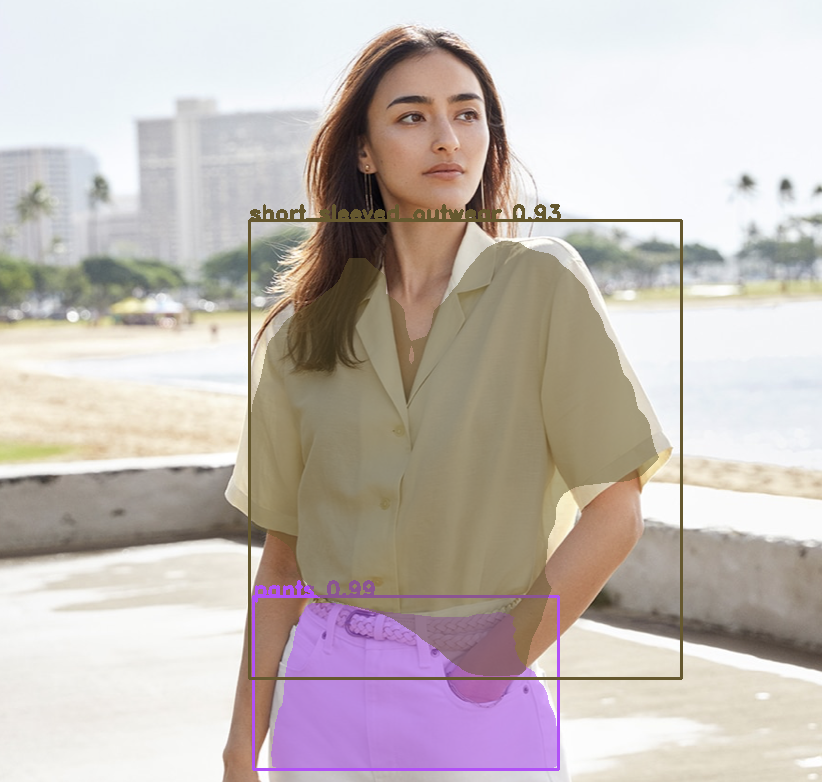

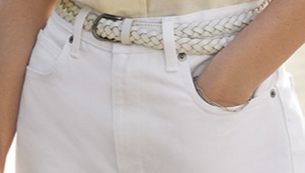

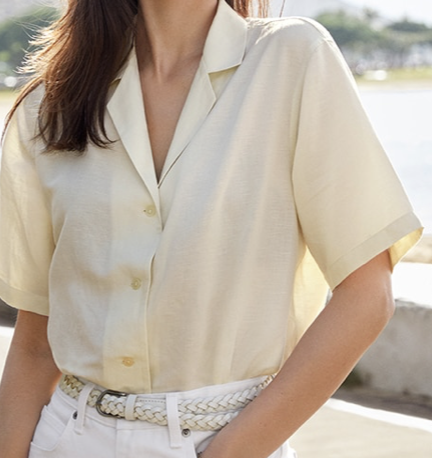

In [14]:


class TestConfig(Config):
    NAME = "Deepfashion2"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 13
config = TestConfig()



# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True)
# ap.add_argument("-o", "--output", required=True)
# args = vars(ap.parse_args())

# input_image = args["input"]
# output = args["output"]


model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)
model.load_weights(MODEL_PATH, by_name=True)


class_names = ['short_sleeved_shirt', 'long_sleeved_shirt', 'short_sleeved_outwear', 'long_sleeved_outwear', 'vest', 'sling', 
               'shorts', 'pants', 'skirt', 'short_sleeved_dress', 'long_sleeved_dress',
               'vest_dress', 'sling_dress','']
cropped_images=[]
def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors

colors = random_colors(len(class_names))
class_dict = {
    name: color for name, color in zip(class_names, colors)
}

def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):
    image_to_crop = image.copy()
    n_instances = boxes.shape[0]
    print("no of potholes in frame :",n_instances)
    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]
        
    for i in range(n_instances):
        if not np.any(boxes[i]):
            continue
        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        color = class_dict[label]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        random_name = str(uuid.uuid4())
        mask = masks[:, :, i]  

        cropped_images.append(image_to_crop[y1:y2, x1:x2])

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(image, caption, (x1, y1), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 2)
        
        


    return image

url='https://firebasestorage.googleapis.com/v0/b/tailor-made-ece188.appspot.com/o/images%2Fece188%2Funiqlo%20fit?alt=media&token=3407982d-0d3d-451f-bbac-c4e92c9d4ec4'
input_image = io.imread(url)


urllib.request.urlretrieve(url, "transferImage.jpg")

frame = cv2.imread("/content/transferImage.jpg")
results = model.detect([frame], verbose=0)
r = results[0]
masked_image = display_instances(frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
cv2_imshow(masked_image)

i=1
for c in cropped_images:
  cv2_imshow(c)
  cv2.imwrite("output_image"+str(i)+".jpg",c)
  i=i+1


In [9]:
keras.models.save_model(model.keras_model,"clothing_mask_rcnn.hdf5")
